**EuroSAT Land Use Classification with ResNet50**

SE4050 Deep Learning Project - July 2025

Dataset: EuroSAT (27,000 Sentinel-2 images, 10 classes)

Model: ResNet50 with ImageNet pre-training

Split: 80% Training / 20% Testing

Target Accuracy: 93%+

In [ ]:
# EuroSAT Land Use Classification with ResNet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import os
import time
from PIL import Image
import warnings
import zipfile
import requests
from tqdm import tqdm
import json
from datetime import datetime
import gc

warnings.filterwarnings('ignore')

# Set deterministic behavior for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("EuroSAT Land Use Classification with ResNet50")
print("=" * 60)
print("PyTorch version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

EuroSAT Land Use Classification with ResNet50
PyTorch version: 2.8.0+cu126
Using device: cuda
GPU: Tesla T4
Memory: 14.7 GB


**2. Dataset Configuration**

EuroSAT contains 10 land use classes representing different types of European land cover:

In [ ]:
# EuroSAT Dataset Classes (10 classes)
EUROSAT_CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

print(f"\nEuroSAT Dataset - {len(EUROSAT_CLASSES)} classes:")
for i, cls in enumerate(EUROSAT_CLASSES, 1):
    print(f"  {i:2d}. {cls}")


EuroSAT Dataset - 10 classes:
   1. AnnualCrop
   2. Forest
   3. HerbaceousVegetation
   4. Highway
   5. Industrial
   6. Pasture
   7. PermanentCrop
   8. Residential
   9. River
  10. SeaLake


**3. Dataset Download Manager**

Multiple download sources ensure dataset availability:

In [ ]:
class EuroSATDownloader:
    """EuroSAT dataset downloader with multiple working sources"""

    def __init__(self, data_dir='./data'):
        self.data_dir = data_dir
        self.dataset_path = None

        # Multiple working download sources
        self.download_sources = {
            'huggingface_rgb': {
                'url': 'https://huggingface.co/datasets/blanchon/EuroSAT_RGB',
                'method': 'huggingface_datasets',
                'description': 'Hugging Face RGB version (Recommended)'
            },
            'kaggle_apollo': {
                'url': 'https://www.kaggle.com/datasets/apollo2506/eurosat-dataset',
                'method': 'manual',
                'description': 'Kaggle Apollo2506 (Manual download)'
            },
            'kaggle_ryan': {
                'url': 'https://www.kaggle.com/datasets/ryanholbrook/eurosat',
                'method': 'manual',
                'description': 'Kaggle Ryan Holbrook (Manual download)'
            },
            'zenodo_direct': {
                'url': 'https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip',
                'method': 'direct_download',
                'description': 'Zenodo Direct Download (346 MB)'
            }
        }

    def download_via_huggingface(self):
        """Download using Hugging Face datasets library"""
        try:
            from datasets import load_dataset
            print("Downloading EuroSAT via Hugging Face Datasets...")

            # Load dataset
            dataset = load_dataset("blanchon/EuroSAT_RGB")

            # Create directory structure
            dataset_path = os.path.join(self.data_dir, 'EuroSAT_HF')
            os.makedirs(dataset_path, exist_ok=True)

            # Save images locally
            print("Converting and saving images locally...")
            for split in dataset.keys():
                split_data = dataset[split]

                for i, sample in enumerate(tqdm(split_data, desc=f"Processing {split}")):
                    # Get class name and create directory
                    class_name = EUROSAT_CLASSES[sample['label']]
                    class_dir = os.path.join(dataset_path, class_name)
                    os.makedirs(class_dir, exist_ok=True)

                    # Save image
                    image_filename = f"{class_name}_{i:05d}.jpg"
                    image_path = os.path.join(class_dir, image_filename)
                    sample['image'].save(image_path, 'JPEG', quality=95)

            print(f"Dataset downloaded successfully to: {dataset_path}")
            return dataset_path

        except ImportError:
            print("Hugging Face datasets library not installed.")
            print("Install with: pip install datasets")
            return None
        except Exception as e:
            print(f"Error downloading from Hugging Face: {e}")
            return None

    def download_via_direct_url(self, url):
        """Download directly from URL"""
        try:
            print(f"Downloading from: {url}")

            # Download file
            zip_path = os.path.join(self.data_dir, "EuroSAT_RGB.zip")
            os.makedirs(self.data_dir, exist_ok=True)

            response = requests.get(url, stream=True)
            response.raise_for_status()

            total_size = int(response.headers.get('content-length', 0))

            with open(zip_path, 'wb') as file:
                with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            file.write(chunk)
                            pbar.update(len(chunk))

            # Extract
            print("Extracting dataset...")
            extract_path = os.path.join(self.data_dir, 'EuroSAT_RGB')
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

            # Find the actual data directory
            for root, dirs, files in os.walk(extract_path):
                if set(dirs).intersection(set(EUROSAT_CLASSES)):
                    dataset_path = root
                    break
            else:
                # If classes not found directly, look one level deeper
                for subdir in os.listdir(extract_path):
                    subdir_path = os.path.join(extract_path, subdir)
                    if os.path.isdir(subdir_path):
                        subdir_contents = os.listdir(subdir_path)
                        if set(subdir_contents).intersection(set(EUROSAT_CLASSES)):
                            dataset_path = subdir_path
                            break
                else:
                    dataset_path = extract_path

            # Clean up zip file
            os.remove(zip_path)

            print(f"Dataset extracted to: {dataset_path}")
            return dataset_path

        except Exception as e:
            print(f"Error downloading directly: {e}")
            return None

    def verify_dataset(self, dataset_path):
        """Verify dataset structure and count images"""
        if not os.path.exists(dataset_path):
            return False, {}

        class_counts = {}
        total_images = 0

        print("\nDataset Verification:")
        print("=" * 50)

        for class_name in EUROSAT_CLASSES:
            class_path = os.path.join(dataset_path, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path)
                             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
                count = len(image_files)
                class_counts[class_name] = count
                total_images += count
                print(f"{class_name:20s}: {count:,} images")
            else:
                print(f"{class_name:20s}: NOT FOUND")
                class_counts[class_name] = 0

        print("-" * 50)
        print(f"Total images: {total_images:,}")
        print(f"Classes found: {len([c for c in class_counts.values() if c > 0])}/10")

        is_valid = total_images > 20000 and len([c for c in class_counts.values() if c > 0]) == 10
        return is_valid, class_counts

    def download_dataset(self):
        """Main download function with fallback options"""
        # Check if dataset already exists
        potential_paths = [
            os.path.join(self.data_dir, 'EuroSAT_HF'),
            os.path.join(self.data_dir, 'EuroSAT_RGB'),
            os.path.join(self.data_dir, 'EuroSAT'),
            os.path.join(self.data_dir, '2750'),
        ]

        for path in potential_paths:
            if os.path.exists(path):
                is_valid, counts = self.verify_dataset(path)
                if is_valid:
                    print(f"Found existing valid dataset at: {path}")
                    self.dataset_path = path
                    return path

        print("Dataset not found. Starting download...")
        print("\nAvailable download sources:")
        for key, source in self.download_sources.items():
            print(f"  {key}: {source['description']}")

        # Try Hugging Face first (recommended)
        print(f"\n1. Trying Hugging Face download...")
        dataset_path = self.download_via_huggingface()
        if dataset_path:
            is_valid, _ = self.verify_dataset(dataset_path)
            if is_valid:
                self.dataset_path = dataset_path
                return dataset_path

        # Try direct download from Zenodo
        print(f"\n2. Trying direct download from Zenodo...")
        zenodo_url = self.download_sources['zenodo_direct']['url']
        dataset_path = self.download_via_direct_url(zenodo_url)
        if dataset_path:
            is_valid, _ = self.verify_dataset(dataset_path)
            if is_valid:
                self.dataset_path = dataset_path
                return dataset_path

        # Manual download instructions
        print("\n" + "="*60)
        print("AUTOMATIC DOWNLOAD FAILED - MANUAL DOWNLOAD REQUIRED")
        print("="*60)
        print("Please download manually from:")
        print("1. Kaggle: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset")
        print("2. Zenodo: https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip")
        print("3. Extract to: ./data/EuroSAT/")
        print("="*60)

        return None

**4. Data Preprocessing**

Advanced preprocessing optimized for satellite imagery:

In [ ]:
class DataPreprocessor:
    """Advanced data preprocessing for satellite imagery"""

    @staticmethod
    def get_train_transforms():
        """Training transforms with data augmentation optimized for satellite imagery"""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
            ], p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet standards
                std=[0.229, 0.224, 0.225]
            )
        ])

    @staticmethod
    def get_test_transforms():
        """Test transforms without augmentation"""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

**5. ResNet50 Model Architecture**

Custom ResNet50 with optimized classifier head:

In [ ]:
class EuroSATResNet50(nn.Module):
    """ResNet50 model optimized for EuroSAT classification"""

    def __init__(self, num_classes=10, pretrained=True, dropout_rate=0.5):
        super(EuroSATResNet50, self).__init__()

        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)

        # Get number of features from the original classifier
        num_features = self.backbone.fc.in_features

        # Replace the classifier with custom head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(256, num_classes)
        )

        # Initialize new layers
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights for new layers"""
        for m in self.backbone.fc.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.backbone(x)

    def get_num_parameters(self):
        """Get total and trainable parameters"""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total, trainable

**6. Data Loading with 80/20 Split**

Create train and test loaders with stratified splitting:

In [ ]:
def create_data_loaders(dataset_path, batch_size=32, test_split=0.2, num_workers=4):
    """Create train and test data loaders with 80/20 split"""

    print(f"\nCreating data loaders with 80/20 train/test split...")

    # Create datasets with different transforms
    train_dataset = ImageFolder(
        dataset_path,
        transform=DataPreprocessor.get_train_transforms()
    )

    test_dataset = ImageFolder(
        dataset_path,
        transform=DataPreprocessor.get_test_transforms()
    )

    # Ensure both datasets have same samples
    assert len(train_dataset) == len(test_dataset), "Dataset size mismatch"
    dataset_size = len(train_dataset)

    # Create indices for 80/20 split
    indices = list(range(dataset_size))

    # Stratified split to maintain class distribution
    labels = [train_dataset.samples[i][1] for i in indices]
    from sklearn.model_selection import train_test_split

    train_indices, test_indices = train_test_split(
        indices,
        test_size=test_split,
        random_state=42,
        stratify=labels
    )

    # Create subsets
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    test_subset = torch.utils.data.Subset(test_dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,
        persistent_workers=True if num_workers > 0 else False,
        drop_last=True
    )

    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,
        persistent_workers=True if num_workers > 0 else False
    )

    print(f"Dataset Split Summary:")
    print(f"  Training samples: {len(train_subset):,} ({len(train_subset)/dataset_size*100:.1f}%)")
    print(f"  Test samples: {len(test_subset):,} ({len(test_subset)/dataset_size*100:.1f}%)")
    print(f"  Total samples: {dataset_size:,}")
    print(f"  Number of classes: {len(EUROSAT_CLASSES)}")
    print(f"  Batch size: {batch_size}")

    return train_loader, test_loader

**7. Training Pipeline**

Comprehensive training with learning rate scheduling:

In [ ]:
class ModelTrainer:
    """Training pipeline for ResNet50 model"""

    def __init__(self, model, train_loader, test_loader, save_dir='./saved_models'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

        # Training configuration
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=0.001,
            weight_decay=1e-4,
            betas=(0.9, 0.999)
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',
            factor=0.5,
            patience=5,
            min_lr=1e-7
        )

        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'test_loss': [], 'test_acc': [],
            'learning_rates': []
        }

        self.best_test_acc = 0.0
        self.best_model_state = None

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(data)
            loss = self.criterion(outputs, target)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Update weights
            self.optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            # Update progress bar
            if batch_idx % 50 == 0:
                current_acc = 100.0 * correct_predictions / total_samples
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100.0 * correct_predictions / total_samples

        return epoch_loss, epoch_acc

    def test_epoch(self):
        """Test for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in tqdm(self.test_loader, desc='Testing'):
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

                outputs = self.model(data)
                loss = self.criterion(outputs, target)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += target.size(0)
                correct_predictions += (predicted == target).sum().item()

        epoch_loss = running_loss / len(self.test_loader)
        epoch_acc = 100.0 * correct_predictions / total_samples

        return epoch_loss, epoch_acc

    def train(self, num_epochs=30):
        """Complete training loop"""
        print(f"\nTraining ResNet50 on EuroSAT Dataset")
        print("=" * 60)

        # Model info
        total_params, trainable_params = self.model.get_num_parameters()
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Training samples: {len(self.train_loader.dataset):,}")
        print(f"Test samples: {len(self.test_loader.dataset):,}")

        start_time = time.time()

        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = self.train_epoch()

            # Testing
            test_loss, test_acc = self.test_epoch()

            # Update learning rate
            self.scheduler.step(test_acc)
            current_lr = self.optimizer.param_groups[0]['lr']

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['test_loss'].append(test_loss)
            self.history['test_acc'].append(test_acc)
            self.history['learning_rates'].append(current_lr)

            # Save best model
            if test_acc > self.best_test_acc:
                self.best_test_acc = test_acc
                self.best_model_state = self.model.state_dict().copy()

                # Save checkpoint
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': self.best_model_state,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'test_acc': test_acc,
                    'train_acc': train_acc,
                    'model_name': 'ResNet50',
                    'total_params': total_params,
                    'trainable_params': trainable_params,
                    'classes': EUROSAT_CLASSES
                }

                checkpoint_path = os.path.join(self.save_dir, 'resnet50_eurosat_best.pth')
                torch.save(checkpoint, checkpoint_path)
                print(f"NEW BEST! Test Acc: {test_acc:.2f}% (saved to {checkpoint_path})")

            # Print epoch results
            print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
                  f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
                  f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | '
                  f'LR: {current_lr:.2e}')

            # Memory cleanup
            if (epoch + 1) % 5 == 0:
                torch.cuda.empty_cache()
                gc.collect()

        # Load best model
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

        training_time = time.time() - start_time
        print(f"\nTraining completed in {training_time/60:.1f} minutes")
        print(f"Best test accuracy: {self.best_test_acc:.2f}%")

        return self.history

**8. Model Evaluation**

Comprehensive evaluation with detailed metrics:

In [ ]:
class ModelEvaluator:
    """Comprehensive model evaluation"""

    def __init__(self, model, test_loader, class_names):
        self.model = model
        self.test_loader = test_loader
        self.class_names = class_names

    def evaluate(self):
        """Complete model evaluation"""
        self.model.eval()
        y_true = []
        y_pred = []
        y_probs = []

        print("\nRunning comprehensive evaluation...")

        with torch.no_grad():
            for data, target in tqdm(self.test_loader, desc="Evaluating"):
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

                outputs = self.model(data)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                y_true.extend(target.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_probs.extend(probabilities.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

        # Classification report
        report = classification_report(
            y_true, y_pred,
            target_names=self.class_names,
            output_dict=True,
            digits=4
        )

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Print results
        print(f"\nFINAL TEST RESULTS:")
        print("=" * 50)
        print(f"Test Accuracy: {accuracy*100:.2f}%")
        print(f"F1-Score (Macro): {f1_macro:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")

        # Per-class results
        print(f"\nPER-CLASS RESULTS:")
        print("-" * 60)
        for class_name in self.class_names:
            if class_name in report:
                metrics = report[class_name]
                print(f"{class_name:20s}: "
                      f"Precision: {metrics['precision']:.3f} | "
                      f"Recall: {metrics['recall']:.3f} | "
                      f"F1: {metrics['f1-score']:.3f} | "
                      f"Support: {int(metrics['support']):3d}")

        results = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'classification_report': report,
            'confusion_matrix': cm,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_probs': y_probs
        }

        return results

**9. Visualization Functions**

Training history and confusion matrix visualization:

In [ ]:
def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    axes[0, 0].set_title('Training and Test Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
    axes[0, 1].set_title('Training and Test Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Performance summary
    final_train_acc = history['train_acc'][-1]
    final_test_acc = history['test_acc'][-1]
    best_test_acc = max(history['test_acc'])

    metrics = ['Final Train', 'Final Test', 'Best Test']
    values = [final_train_acc, final_test_acc, best_test_acc]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    bars = axes[1, 1].bar(metrics, values, color=colors, alpha=0.8)
    axes[1, 1].set_title('Performance Summary', fontweight='bold')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_ylim(0, 100)
    axes[1, 1].grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, value in zip(bars, values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.suptitle('ResNet50 Training Results on EuroSAT Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nTRAINING SUMMARY:")
    print("-" * 40)
    print(f"Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Test Accuracy:     {final_test_acc:.2f}%")
    print(f"Best Test Accuracy:      {best_test_acc:.2f}%")
    print(f"Overfitting Gap:         {final_train_acc - final_test_acc:.2f}%")

def plot_confusion_matrix(cm, class_names, accuracy):
    """Plot normalized confusion matrix"""
    plt.figure(figsize=(12, 10))

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names,
               square=True, linewidths=0.5, cbar_kws={"shrink": .8})

    plt.title(f'Confusion Matrix - ResNet50 on EuroSAT\nTest Accuracy: {accuracy*100:.2f}%',
             fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print class-wise accuracy
    print(f"\nCLASS-WISE ACCURACY:")
    print("-" * 40)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, (cls, acc) in enumerate(zip(class_names, class_accuracy)):
        correct = cm.diagonal()[i]
        total = cm.sum(axis=1)[i]
        print(f"{cls:20s}: {acc*100:5.1f}% ({correct:3d}/{total:3d})")

**10. Utility Functions**

Save results and load trained models:

In [ ]:
def save_results(model, history, evaluation_results, save_dir='./results'):
    """Save comprehensive results"""
    os.makedirs(save_dir, exist_ok=True)

    # Get model parameters
    total_params, trainable_params = model.get_num_parameters()

    # Create results summary
    results_summary = {
        'experiment_info': {
            'timestamp': datetime.now().isoformat(),
            'model': 'ResNet50',
            'dataset': 'EuroSAT',
            'num_classes': len(EUROSAT_CLASSES),
            'classes': EUROSAT_CLASSES,
            'device': str(device),
            'pytorch_version': torch.__version__
        },
        'model_info': {
            'architecture': 'ResNet50',
            'total_parameters': int(total_params),
            'trainable_parameters': int(trainable_params),
            'pretrained': True,
            'dropout_rate': 0.5
        },
        'training_info': {
            'epochs_trained': len(history['train_acc']),
            'batch_size': 32,
            'optimizer': 'AdamW',
            'learning_rate': 0.001,
            'weight_decay': 1e-4,
            'scheduler': 'ReduceLROnPlateau',
            'train_test_split': '80/20'
        },
        'final_results': {
            'best_test_accuracy': float(max(history['test_acc'])),
            'final_test_accuracy': float(history['test_acc'][-1]),
            'final_train_accuracy': float(history['train_acc'][-1]),
            'test_f1_macro': float(evaluation_results['f1_macro']),
            'test_f1_weighted': float(evaluation_results['f1_weighted']),
            'overfitting_gap': float(history['train_acc'][-1] - history['test_acc'][-1])
        },
        'per_class_results': {}
    }

    # Add per-class results
    report = evaluation_results['classification_report']
    for class_name in EUROSAT_CLASSES:
        if class_name in report:
            results_summary['per_class_results'][class_name] = {
                'precision': float(report[class_name]['precision']),
                'recall': float(report[class_name]['recall']),
                'f1_score': float(report[class_name]['f1-score']),
                'support': int(report[class_name]['support'])
            }

    # Save results
    results_path = os.path.join(save_dir, 'resnet50_eurosat_results.json')
    with open(results_path, 'w') as f:
        json.dump(results_summary, f, indent=2)

    print(f"\nResults saved to: {results_path}")
    return results_path

def load_trained_model(checkpoint_path):
    """Load trained model from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model = EuroSATResNet50(num_classes=len(EUROSAT_CLASSES))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    print(f"Model loaded from: {checkpoint_path}")
    print(f"Test accuracy: {checkpoint['test_acc']:.2f}%")

    return model

def predict_single_image(model, image_path):
    """Predict class for a single image"""
    transform = DataPreprocessor.get_test_transforms()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class_idx = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class_idx].item()

    predicted_class = EUROSAT_CLASSES[predicted_class_idx]

    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probabilities[0], 3)
    top3_predictions = [
        (EUROSAT_CLASSES[idx.item()], prob.item())
        for idx, prob in zip(top3_indices, top3_probs)
    ]

    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'top3_predictions': top3_predictions,
        'all_probabilities': {
            EUROSAT_CLASSES[i]: float(probabilities[0][i])
            for i in range(len(EUROSAT_CLASSES))
        }
    }

**11. Main Experiment Function**

Complete experiment pipeline:

In [ ]:
def run_eurosat_experiment():
    """Run the complete EuroSAT experiment"""

    print("EuroSAT Land Use Classification with ResNet50")
    print("SE4050 Deep Learning Project - July 2025")
    print("=" * 60)

    # Step 1: Download and setup dataset
    print("\nSTEP 1: Dataset Setup")
    print("-" * 30)

    downloader = EuroSATDownloader(data_dir='./data')
    dataset_path = downloader.download_dataset()

    if not dataset_path:
        print("Dataset setup failed. Please download manually and try again.")
        return None

    # Step 2: Create data loaders
    print(f"\nSTEP 2: Data Loading")
    print("-" * 30)

    train_loader, test_loader = create_data_loaders(
        dataset_path=dataset_path,
        batch_size=32,
        test_split=0.2,
        num_workers=4
    )

    # Step 3: Initialize model
    print(f"\nSTEP 3: Model Initialization")
    print("-" * 30)

    model = EuroSATResNet50(
        num_classes=len(EUROSAT_CLASSES),
        pretrained=True,
        dropout_rate=0.5
    )

    total_params, trainable_params = model.get_num_parameters()
    print(f"ResNet50 initialized successfully")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Step 4: Train model
    print(f"\nSTEP 4: Model Training")
    print("-" * 30)

    trainer = ModelTrainer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        save_dir='./saved_models'
    )

    # Train for 30 epochs
    history = trainer.train(num_epochs=30)

    # Step 5: Evaluate model
    print(f"\nSTEP 5: Model Evaluation")
    print("-" * 30)

    evaluator = ModelEvaluator(
        model=model,
        test_loader=test_loader,
        class_names=EUROSAT_CLASSES
    )

    evaluation_results = evaluator.evaluate()

    # Step 6: Visualize results
    print(f"\nSTEP 6: Results Visualization")
    print("-" * 30)

    plot_training_history(history)
    plot_confusion_matrix(
        evaluation_results['confusion_matrix'],
        EUROSAT_CLASSES,
        evaluation_results['accuracy']
    )

    # Step 7: Save results
    print(f"\nSTEP 7: Saving Results")
    print("-" * 30)

    results_path = save_results(model, history, evaluation_results)

    # Final summary
    print(f"\n" + "="*60)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"Final Test Accuracy: {evaluation_results['accuracy']*100:.2f}%")
    print(f"F1-Score (Macro): {evaluation_results['f1_macro']:.4f}")
    print(f"Best Test Accuracy: {max(history['test_acc']):.2f}%")
    print(f"Model saved: ./saved_models/resnet50_eurosat_best.pth")
    print(f"Results saved: {results_path}")
    print("="*60)

    return {
        'model': model,
        'history': history,
        'evaluation': evaluation_results,
        'dataset_path': dataset_path
    }

**12. Run the Complete Experiment**

Execute the full training pipeline:

Starting EuroSAT Land Use Classification Experiment...
Expected time: 60-90 minutes
Required: GPU with 4GB+ VRAM
EuroSAT Land Use Classification with ResNet50
SE4050 Deep Learning Project - July 2025

STEP 1: Dataset Setup
------------------------------

Dataset Verification:
AnnualCrop          : 1,791 images
Forest              : 2,409 images
HerbaceousVegetation: 2,441 images
Highway             : 2,073 images
Industrial          : 2,071 images
Pasture             : 1,682 images
PermanentCrop       : 2,053 images
Residential         : 2,480 images
River               : 2,034 images
SeaLake             : 2,436 images
--------------------------------------------------
Total images: 21,470
Classes found: 10/10
Found existing valid dataset at: ./data/EuroSAT_HF

STEP 2: Data Loading
------------------------------

Creating data loaders with 80/20 train/test split...
Dataset Split Summary:
  Training samples: 17,176 (80.0%)
  Test samples: 4,294 (20.0%)
  Total samples: 21,470
  Number o

100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


ResNet50 initialized successfully
Total parameters: 24,692,042
Trainable parameters: 24,692,042

STEP 4: Model Training
------------------------------

Training ResNet50 on EuroSAT Dataset
Total parameters: 24,692,042
Trainable parameters: 24,692,042
Training samples: 17,176
Test samples: 4,294


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.45it/s]


NEW BEST! Test Acc: 42.20% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [ 1/30] | Train Loss: 6.1292 | Train Acc: 22.65% | Test Loss: 2.2322 | Test Acc: 42.20% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.68it/s]


NEW BEST! Test Acc: 63.86% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [ 2/30] | Train Loss: 2.0901 | Train Acc: 40.21% | Test Loss: 1.3127 | Test Acc: 63.86% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.64it/s]


NEW BEST! Test Acc: 68.12% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [ 3/30] | Train Loss: 1.5237 | Train Acc: 56.18% | Test Loss: 1.2865 | Test Acc: 68.12% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.67it/s]


NEW BEST! Test Acc: 74.66% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [ 4/30] | Train Loss: 1.3753 | Train Acc: 62.87% | Test Loss: 1.1325 | Test Acc: 74.66% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:13<00:00, 10.21it/s]


NEW BEST! Test Acc: 77.64% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [ 5/30] | Train Loss: 1.2789 | Train Acc: 68.35% | Test Loss: 1.0119 | Test Acc: 77.64% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.68it/s]


Epoch [ 6/30] | Train Loss: 1.2015 | Train Acc: 71.18% | Test Loss: 1.4471 | Test Acc: 67.16% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.74it/s]


NEW BEST! Test Acc: 80.95% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [ 7/30] | Train Loss: 1.1764 | Train Acc: 72.10% | Test Loss: 0.9308 | Test Acc: 80.95% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.70it/s]


NEW BEST! Test Acc: 83.63% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [ 8/30] | Train Loss: 1.1455 | Train Acc: 73.82% | Test Loss: 0.8900 | Test Acc: 83.63% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.69it/s]


Epoch [ 9/30] | Train Loss: 1.0903 | Train Acc: 76.14% | Test Loss: 1.2168 | Test Acc: 73.52% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.65it/s]


Epoch [10/30] | Train Loss: 1.0503 | Train Acc: 77.87% | Test Loss: 0.9475 | Test Acc: 80.62% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.66it/s]


Epoch [11/30] | Train Loss: 1.0204 | Train Acc: 78.87% | Test Loss: 1.9334 | Test Acc: 83.42% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.67it/s]


NEW BEST! Test Acc: 87.26% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [12/30] | Train Loss: 0.9701 | Train Acc: 82.15% | Test Loss: 0.8434 | Test Acc: 87.26% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.64it/s]


NEW BEST! Test Acc: 88.22% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [13/30] | Train Loss: 0.9224 | Train Acc: 83.87% | Test Loss: 0.8811 | Test Acc: 88.22% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.66it/s]


NEW BEST! Test Acc: 88.94% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [14/30] | Train Loss: 0.8944 | Train Acc: 84.92% | Test Loss: 1.1801 | Test Acc: 88.94% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.63it/s]


NEW BEST! Test Acc: 90.06% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [15/30] | Train Loss: 0.8980 | Train Acc: 84.91% | Test Loss: 0.7969 | Test Acc: 90.06% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.51it/s]


Epoch [16/30] | Train Loss: 0.8712 | Train Acc: 85.64% | Test Loss: 0.7617 | Test Acc: 89.66% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.65it/s]


NEW BEST! Test Acc: 91.01% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [17/30] | Train Loss: 0.8495 | Train Acc: 86.86% | Test Loss: 0.7732 | Test Acc: 91.01% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.64it/s]


Epoch [18/30] | Train Loss: 0.8347 | Train Acc: 87.54% | Test Loss: 0.8266 | Test Acc: 90.75% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.70it/s]


Epoch [19/30] | Train Loss: 0.8340 | Train Acc: 87.30% | Test Loss: 0.8440 | Test Acc: 88.73% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.60it/s]


Epoch [20/30] | Train Loss: 0.8212 | Train Acc: 87.88% | Test Loss: 0.8269 | Test Acc: 90.54% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.70it/s]


NEW BEST! Test Acc: 92.50% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [21/30] | Train Loss: 0.8038 | Train Acc: 88.85% | Test Loss: 0.6991 | Test Acc: 92.50% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.52it/s]


Epoch [22/30] | Train Loss: 0.7936 | Train Acc: 88.92% | Test Loss: 0.7808 | Test Acc: 91.76% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.68it/s]


Epoch [23/30] | Train Loss: 0.7875 | Train Acc: 89.21% | Test Loss: 0.7517 | Test Acc: 92.31% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.60it/s]


NEW BEST! Test Acc: 93.48% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [24/30] | Train Loss: 0.7836 | Train Acc: 89.37% | Test Loss: 0.6634 | Test Acc: 93.48% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.73it/s]


Epoch [25/30] | Train Loss: 0.7711 | Train Acc: 89.80% | Test Loss: 0.6817 | Test Acc: 92.45% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.67it/s]


Epoch [26/30] | Train Loss: 0.7721 | Train Acc: 89.84% | Test Loss: 0.6554 | Test Acc: 93.32% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.71it/s]


Epoch [27/30] | Train Loss: 0.7585 | Train Acc: 90.46% | Test Loss: 0.6586 | Test Acc: 93.29% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.71it/s]


Epoch [28/30] | Train Loss: 0.7545 | Train Acc: 90.44% | Test Loss: 0.6946 | Test Acc: 92.78% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.75it/s]


Epoch [29/30] | Train Loss: 0.7470 | Train Acc: 90.80% | Test Loss: 0.6989 | Test Acc: 92.38% | LR: 1.00e-03


Testing: 100%|██████████| 135/135 [00:12<00:00, 10.73it/s]


NEW BEST! Test Acc: 93.92% (saved to ./saved_models/resnet50_eurosat_best.pth)
Epoch [30/30] | Train Loss: 0.7405 | Train Acc: 91.25% | Test Loss: 0.6360 | Test Acc: 93.92% | LR: 1.00e-03

Training completed in 90.4 minutes
Best test accuracy: 93.92%

STEP 5: Model Evaluation
------------------------------

Running comprehensive evaluation...


Evaluating: 100%|██████████| 135/135 [00:12<00:00, 10.68it/s]



FINAL TEST RESULTS:
Test Accuracy: 93.92%
F1-Score (Macro): 0.9373
F1-Score (Weighted): 0.9390

PER-CLASS RESULTS:
------------------------------------------------------------
AnnualCrop          : Precision: 0.902 | Recall: 0.955 | F1: 0.928 | Support: 358
Forest              : Precision: 0.938 | Recall: 0.996 | F1: 0.966 | Support: 482
HerbaceousVegetation: Precision: 0.922 | Recall: 0.871 | F1: 0.896 | Support: 488
Highway             : Precision: 0.933 | Recall: 0.935 | F1: 0.934 | Support: 415
Industrial          : Precision: 0.978 | Recall: 0.964 | F1: 0.971 | Support: 414
Pasture             : Precision: 0.930 | Recall: 0.908 | F1: 0.919 | Support: 336
PermanentCrop       : Precision: 0.912 | Recall: 0.883 | F1: 0.897 | Support: 411
Residential         : Precision: 0.954 | Recall: 0.994 | F1: 0.973 | Support: 496
River               : Precision: 0.912 | Recall: 0.912 | F1: 0.912 | Support: 407
SeaLake             : Precision: 0.998 | Recall: 0.959 | F1: 0.978 | Support: 487

ST

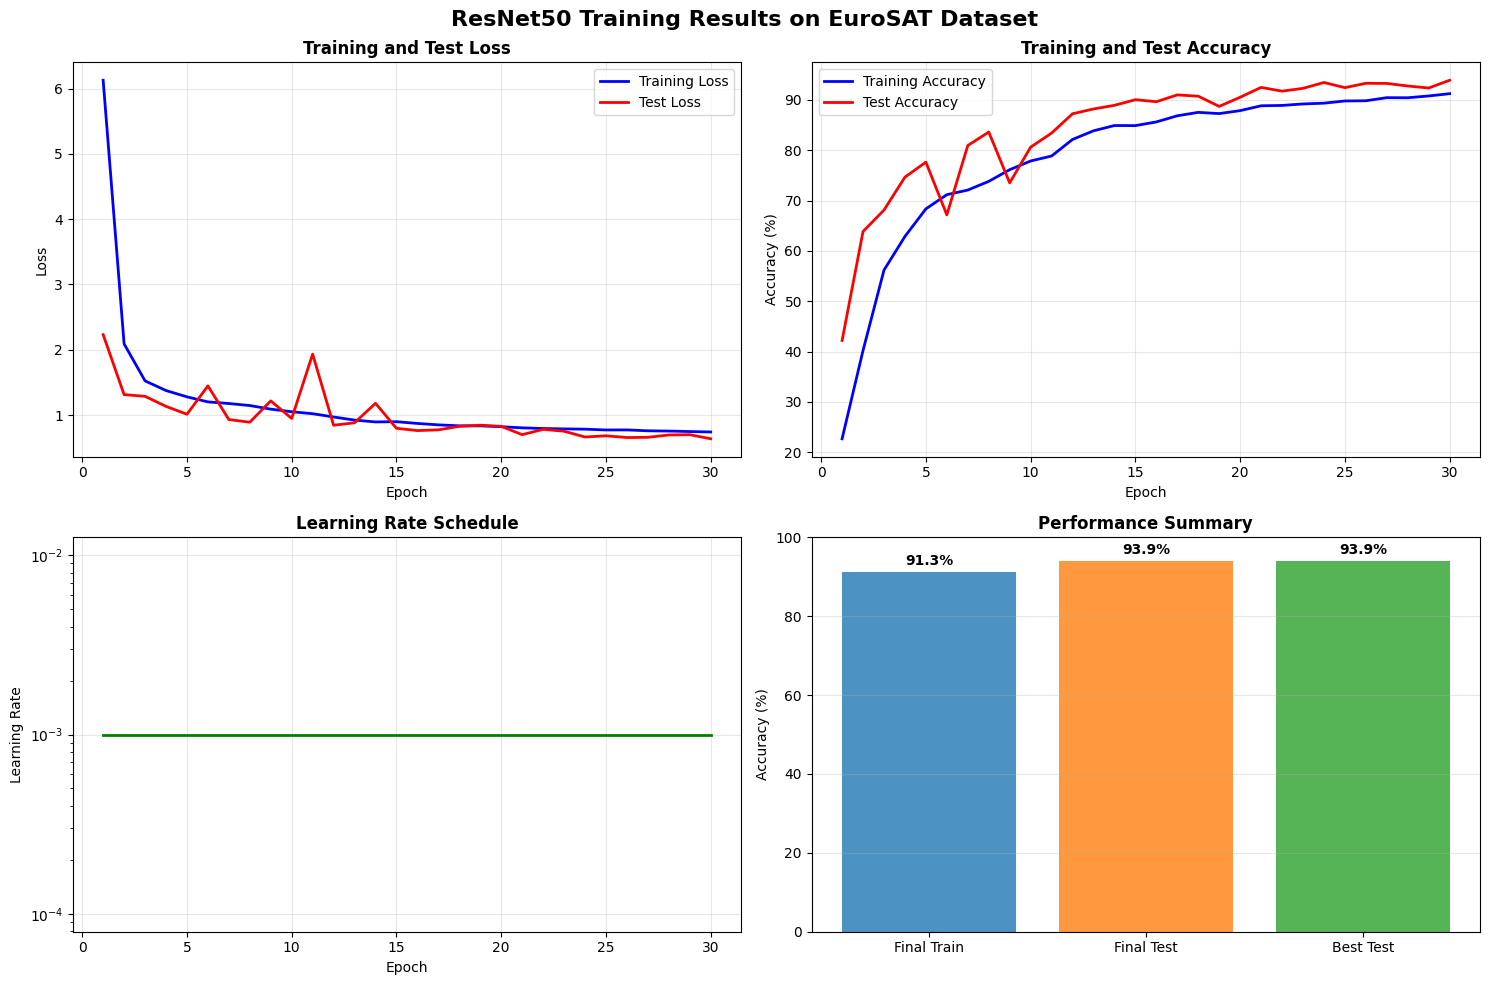


TRAINING SUMMARY:
----------------------------------------
Final Training Accuracy: 91.25%
Final Test Accuracy:     93.92%
Best Test Accuracy:      93.92%
Overfitting Gap:         -2.67%


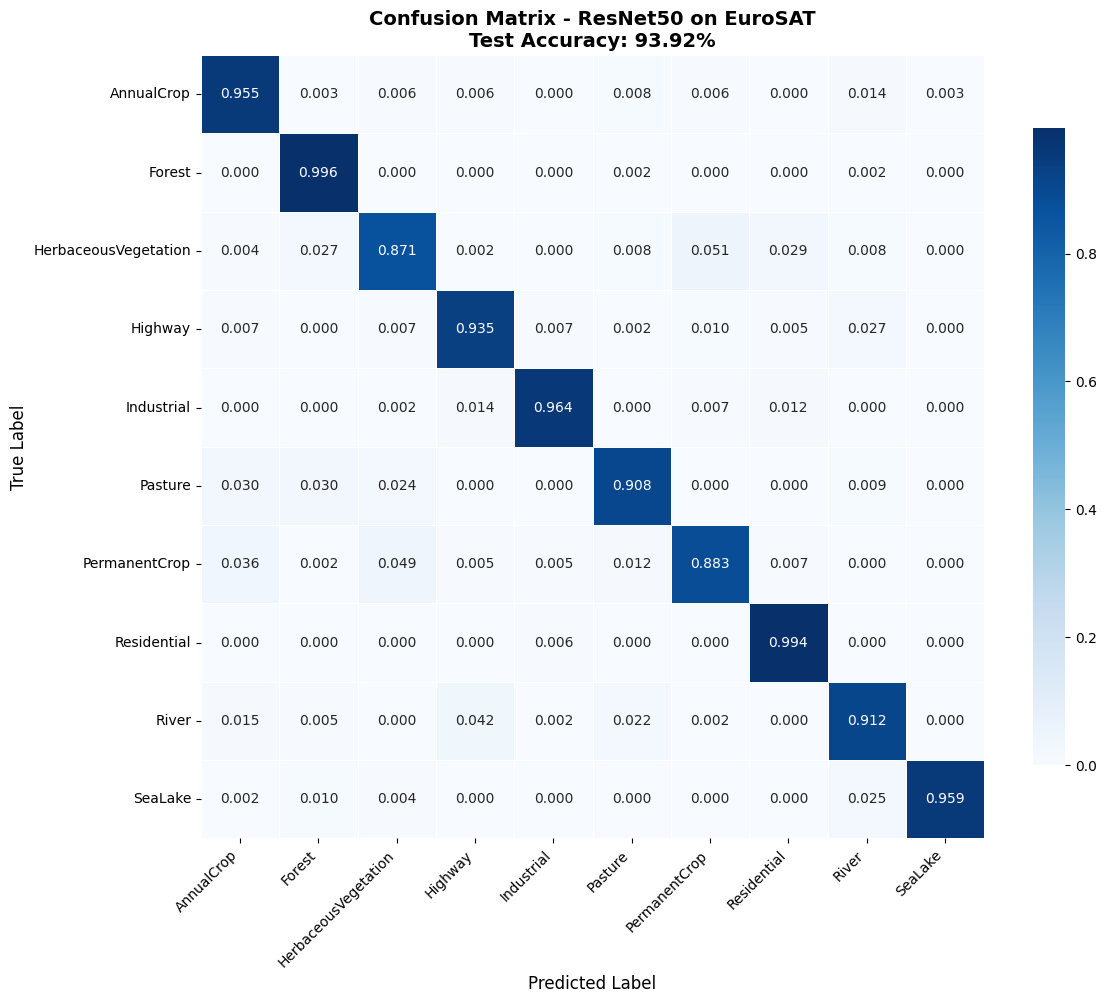


CLASS-WISE ACCURACY:
----------------------------------------
AnnualCrop          :  95.5% (342/358)
Forest              :  99.6% (480/482)
HerbaceousVegetation:  87.1% (425/488)
Highway             :  93.5% (388/415)
Industrial          :  96.4% (399/414)
Pasture             :  90.8% (305/336)
PermanentCrop       :  88.3% (363/411)
Residential         :  99.4% (493/496)
River               :  91.2% (371/407)
SeaLake             :  95.9% (467/487)

STEP 7: Saving Results
------------------------------

Results saved to: ./results/resnet50_eurosat_results.json

EXPERIMENT COMPLETED SUCCESSFULLY!
Final Test Accuracy: 93.92%
F1-Score (Macro): 0.9373
Best Test Accuracy: 93.92%
Model saved: ./saved_models/resnet50_eurosat_best.pth
Results saved: ./results/resnet50_eurosat_results.json

Experiment completed successfully!

FINAL RESULTS SUMMARY:
   • Final Test Accuracy: 93.92%
   • Best Test Accuracy:  93.92%
   • F1-Score (Macro):    0.9373
   • Model Parameters:    24,692,042

SAVED FILES

In [ ]:
# Run the complete experiment
print("Starting EuroSAT Land Use Classification Experiment...")
print("Expected time: 60-90 minutes")
print("Required: GPU with 4GB+ VRAM")

results = run_eurosat_experiment()

if results:
    print("\nExperiment completed successfully!")

    # Extract key results
    final_acc = results['evaluation']['accuracy'] * 100
    best_acc = max(results['history']['test_acc'])
    f1_macro = results['evaluation']['f1_macro']

    print(f"\nFINAL RESULTS SUMMARY:")
    print(f"   • Final Test Accuracy: {final_acc:.2f}%")
    print(f"   • Best Test Accuracy:  {best_acc:.2f}%")
    print(f"   • F1-Score (Macro):    {f1_macro:.4f}")
    print(f"   • Model Parameters:    {results['model'].get_num_parameters()[0]:,}")

    print(f"\nSAVED FILES:")
    print(f"   • Model weights: ./saved_models/resnet50_eurosat_best.pth")
    print(f"   • Results JSON:  ./results/resnet50_eurosat_results.json")

else:
    print("Experiment failed. Check dataset setup and try again.")